In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
from random import seed # for setting seed
import tensorflow
from IPython import sys_info
import os
import gc # garbage collection
import random
import os
import shutil

In [3]:
from tensorflow.python.client import device_lib
# print out the CPUs and GPUs
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1082348545133121300
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13858871960892746499
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [4]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [5]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence


In [6]:
folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_ARTISTS_WITH_100_PICTURES'

# List the files in the folder
all_pictures = os.listdir(folder)

file_path = "/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_ARTISTS_WITH_100_PICTURES.csv"
df = pd.read_csv(file_path)
print(df.head())

NUM_CLASSES = len(df['artist'].unique().tolist())

print("Number of classes:", NUM_CLASSES)


         artist  date                  genre  pixelsx  pixelsy  size_bytes  \
0  Paul Gauguin  1903         genre painting   1916.0   1688.0    363138.0   
1  Paul Gauguin  1893               portrait   2048.0   1348.0    293452.0   
2  Paul Gauguin  1892  mythological painting   1800.0   1082.0   1638911.0   
3  Paul Gauguin  1903         genre painting   1600.0   1067.0    307130.0   
4  Paul Gauguin  1892               portrait   1096.0   1476.0    467406.0   

    source               style                  title    artist_group  \
0  wikiart  Post-Impressionism         The Invocation  train_and_test   
1  wikiart         Cloisonnism                  Alone  train_and_test   
2  wikiart         Cloisonnism          The Royal End  train_and_test   
3  wikiart  Post-Impressionism  Women and white horse  train_and_test   
4  wikiart  Post-Impressionism            Two sisters  train_and_test   

   in_train new_filename  
0     False    35323.jpg  
1     False    73683.jpg  
2      True

# Create the TEST and TRAIN sets

In [7]:
import shutil

In [8]:
# GROUP THE FILES BY EACH ARTIST
def group_files_per_artist():
  data_per_artist = {}

  # Iterate over each row of the DataFrame
  for index, row in df.iterrows():
      artist = row['artist']
      new_filename = row['new_filename']

      # Check if the artist is already in the dictionary
      if artist in data_per_artist:
          # Add the new_filename to the existing list of the artist
          data_per_artist[artist].append(new_filename)
      else:
          # Create a new list for the artist and add the new_filename
          data_per_artist[artist] = [new_filename]

  return data_per_artist

# SPLIT THE FILES INTO TRAIN AND TEST SETS (CREATE NEW DATASETS)
def split_test_train(data_per_artist, train_percentage = 0.8):

  TRAIN_names = []
  TEST_names = []

  # Iterate over each artist and their 'new_filename'
  for artist, filenames in data_per_artist.items():
      # Calculate the number of files for training and testing
      total_files = len(filenames)
      num_train = int(train_percentage * total_files)

      # Shuffle the filenames to avoid selection biases
      random.shuffle(filenames)

      # Divide the filenames into train and test
      train_filenames = filenames[:num_train]
      test_filenames = filenames[num_train:]

      # Store the divided filenames into train and test
      TRAIN_names.extend(train_filenames)
      TEST_names.extend(test_filenames)
  return TRAIN_names, TEST_names



# CREATE TEST and TRAIN folders
def create_train_test_folders(folder, TRAIN_names, TEST_names):
    # Output folder for TRAIN and TEST
    train_folder = os.path.join(folder, 'TRAIN')
    test_folder = os.path.join(folder, 'TEST')

    # Create TRAIN and TEST folders if they don't exist
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Move images from TRAIN to TRAIN folder
    for filename in TRAIN_names:
        src = os.path.join(folder, filename)
        dst = os.path.join(train_folder, filename)
        shutil.move(src, dst)

    # Move images from TEST to TEST folder
    for filename in TEST_names:
        src = os.path.join(folder, filename)
        dst = os.path.join(test_folder, filename)
        shutil.move(src, dst)

    # Create df_train with rows whose 'new_filename' is in TRAIN_names and keep only 'artist' and 'new_filename' columns
    train_dataframe = df[df['new_filename'].isin(TRAIN_names)][['artist', 'new_filename']]
    # File path for the CSV file
    file_path = os.path.join(folder, 'train_dataframe.csv')
    # Save the DataFrame as CSV
    train_dataframe.to_csv(file_path, index=False)

    # Create df_test with rows whose 'new_filename' is in TEST_names and keep only 'artist' and 'new_filename' columns
    test_dataframe = df[df['new_filename'].isin(TEST_names)][['artist', 'new_filename']]
    # File path for the CSV file
    file_path = os.path.join(folder, 'test_dataframe.csv')
    # Save the DataFrame as CSV
    test_dataframe.to_csv(file_path, index=False)

    return train_dataframe, test_dataframe

if not (os.path.exists(os.path.join(folder, 'TRAIN')) and os.path.exists(os.path.join(folder, 'TEST'))):
  # Group files per artist
  data_per_artist = group_files_per_artist()
  # Print the number of files for each artist
  print("- Artists and numer of images:")
  for key in data_per_artist.keys():
    print(key, len(data_per_artist[key]))

  # Split data
  TRAIN_names, TEST_names = split_test_train(data_per_artist)

  # Use the function to create TRAIN and TEST folders
  train_dataframe, test_dataframe = create_train_test_folders(folder, TRAIN_names, TEST_names)
  print("\nImages successfully moved to TRAIN and TEST folders.")
else:
  print("TRAIN and TEST folders already exist. Reading train and test DataFrames from CSV files...")

  # Read train and test DataFrames from CSV files
  train_csv_path = os.path.join(folder, 'train_dataframe.csv')
  test_csv_path = os.path.join(folder, 'test_dataframe.csv')
  train_dataframe = pd.read_csv(train_csv_path)
  test_dataframe = pd.read_csv(test_csv_path)

  print("Train DataFrame:", train_dataframe.shape)
  print("Test DataFrame:", test_dataframe.shape)

TRAIN and TEST folders already exist. Reading train and test DataFrames from CSV files...
Train DataFrame: (400, 2)
Test DataFrame: (100, 2)


# Prepare the data

In [9]:
from torchvision import datasets, transforms

# Define the transformation to convert images to PyTorch tensors
transf = transforms.Compose([transforms.ToTensor()])

# Paths of the training and testing folders
train_folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_ARTISTS_WITH_100_PICTURES/TRAIN'
test_folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_ARTISTS_WITH_100_PICTURES/TEST'

# Get the file names of training and testing images from the dataframes
train_filenames = train_dataframe['new_filename'].tolist()
test_filenames = test_dataframe['new_filename'].tolist()

print(len(train_filenames))


# Create empty lists for images and labels
train_images = []
train_labels = []
test_images = []
test_labels = []

# Load training images
for filename in train_filenames:
    img_path = os.path.join(train_folder, filename)
    img = Image.open(img_path)
    img_tensor = transf(img)
    train_images.append(img_tensor)
    # Get label from the dataframe
    label = train_dataframe[train_dataframe['new_filename'] == filename]['artist'].iloc[0]
    train_labels.append(label)
# Load testing images
for filename in test_filenames:
    img_path = os.path.join(test_folder, filename)
    img = Image.open(img_path)
    img_tensor = transf(img)
    test_images.append(img_tensor)
    # Get label from the dataframe
    label = test_dataframe[test_dataframe['new_filename'] == filename]['artist'].iloc[0]
    test_labels.append(label)


400


In [10]:
import torch

# Create a dictionary to map artist names to unique numerical values
artist_to_index = {artist: i for i, artist in enumerate(train_dataframe['artist'].unique())}

# Convert string labels to integers using the dictionary
train_labels = [artist_to_index[artist] for artist in train_labels]
test_labels = [artist_to_index[artist] for artist in test_labels]

# Create PyTorch tensors for training and testing images and labels
train_dataset = torch.utils.data.TensorDataset(torch.stack(train_images), torch.tensor(train_labels))
all_test_dataset = torch.utils.data.TensorDataset(torch.stack(test_images), torch.tensor(test_labels))


In [11]:
print(f'Shape of training set: {train_dataset.tensors[0].shape}')
print(f'Shape of test set: {all_test_dataset.tensors[0].shape}')
print(f'Shape of training labels: {train_dataset.tensors[1].shape}')
print(f'Shape of test labels: {all_test_dataset.tensors[1].shape}')

Shape of training set: torch.Size([400, 3, 224, 224])
Shape of test set: torch.Size([100, 3, 224, 224])
Shape of training labels: torch.Size([400])
Shape of test labels: torch.Size([100])


In [12]:
import collections

# Get the labels from the training and test datasets
y_train = train_dataset.tensors[1].tolist()
y_test = all_test_dataset.tensors[1].tolist()

# Count the number of images per category in the training data
counter_train = collections.Counter(y_train)
print('Class Image Counter for Training Data:')
print(counter_train)

# Count the number of images per category in the test data
counter_test = collections.Counter(y_test)
print('\nClass Image Counter for Test Data:')
print(counter_test)


Class Image Counter for Training Data:
Counter({0: 80, 1: 80, 2: 80, 3: 80, 4: 80})

Class Image Counter for Test Data:
Counter({0: 20, 1: 20, 2: 20, 3: 20, 4: 20})


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the labels from the test dataset
y_test = all_test_dataset.tensors[1].tolist()

# Use StratifiedShuffleSplit to split the data into validation set and test set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# Make a list of indices for the test set
indices_test = list(range(len(all_test_dataset)))

# Execute the stratified split
for idx_test, idx_val in split.split(indices_test, y_test):
    print("Test Indices:", idx_test)
    print("Validation Indices:", idx_val)
    print("Number of samples in validation set:", len(idx_val))
    print("Number of samples in test set:", len(idx_test))


Test Indices: [13 56 48 35 79 17 72 95 10  9 30 20 23 69 11 63 55 49 90 74 58 53 70  4
 43 42 76 37  6 29 62 67 31 86 14 39 77 82  1 16 24 21 89 41 38 61 33 97
 75 19 84 50 99  5 85  2 32 46 88 91 44 81  8 28 93 52 51 73 18 96 87 45
 57 98 60 78  7 36 71 22]
Validation Indices: [15 26 54 25 83  0 12 64 65 27 68  3 47 34 94 40 92 59 80 66]
Number of samples in validation set: 20
Number of samples in test set: 80


# Create two datasets from all_test_dataset

In [14]:
from torch.utils.data import Subset

# Use torch utility to make subsets for all_test_dataset

val_dataset = Subset(all_test_dataset, idx_val)  # List of indices for validation split
test_dataset = Subset(all_test_dataset, idx_test)  # List of indices for test split


In [15]:
# Get the labels from the validation and test datasets and convert them to integers
y_val = [int(all_test_dataset[idx][1]) for idx in idx_val]
y_test = [int(all_test_dataset[idx][1]) for idx in idx_test]

# Count the number of images per category in the validation data
counter_val = collections.Counter(y_val)
print('Class Image Counter for Validation Data:')
print(counter_val)

# Count the number of images per category in the test data
counter_test = collections.Counter(y_test)
print('\nClass Image Counter for Test Data:')
print(counter_test)


Class Image Counter for Validation Data:
Counter({0: 4, 1: 4, 2: 4, 4: 4, 3: 4})

Class Image Counter for Test Data:
Counter({0: 16, 2: 16, 1: 16, 3: 16, 4: 16})


In [16]:
import torchvision.utils as utils

def plot_img(img, title=None):
    npimg = img.numpy()
    npimg_T = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_T)
    if title:
        plt.title(title)
    plt.axis('on')
    plt.show()

# Function to visualize samples from a data tensor
def plot_tensor(tensor, random_id=False, class_id=None):
    if random_id:
        rnd_inds = np.random.randint(0, len(tensor), 100)
        X_show = [tensor[i][0] for i in rnd_inds]
    else:
        if class_id is None:
            X_show = []
            for j in range(NUM_CLASSES):  # NUM_CLASSES classes
                ii = -1
                for i in range(len(tensor)):
                    if tensor[i][1] == j:
                        ii += 1
                        if ii > 19:
                            break
                        else:
                            X_show.append(tensor[i][0])
        else:
            print(f'Showing samples from {len(tensor)} tensors:')
            X_show = []
            ii = -1
            for i in range(len(tensor)):
                if tensor[i][1] == class_id:
                    ii += 1
                    if ii > 19:
                        break
                    else:
                        X_show.append(tensor[i][0])

    X_grid = utils.make_grid(X_show, nrow=20, padding=1)
    plot_img(X_grid, title='Image samples from each class')


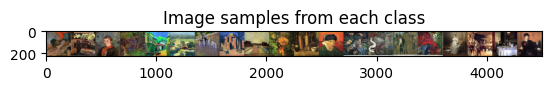

In [17]:
plot_tensor(val_dataset)

Showing samples from 20 tensors:


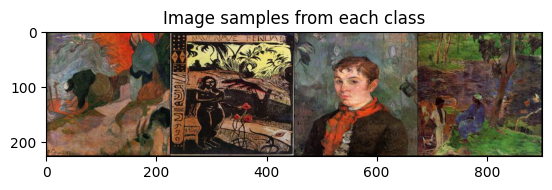

In [18]:
plot_tensor(val_dataset,class_id=0)

Showing samples from 20 tensors:


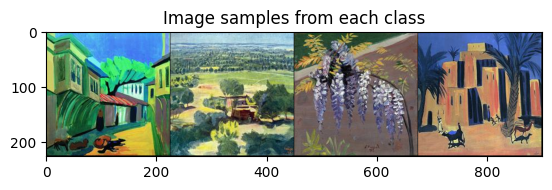

In [19]:
plot_tensor(val_dataset,class_id=1)

Showing samples from 20 tensors:


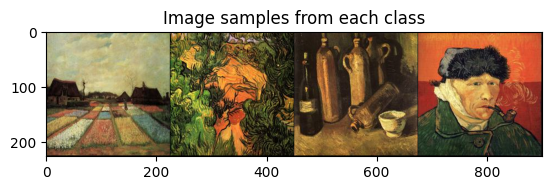

In [20]:
plot_tensor(val_dataset,class_id=2)

Showing samples from 20 tensors:


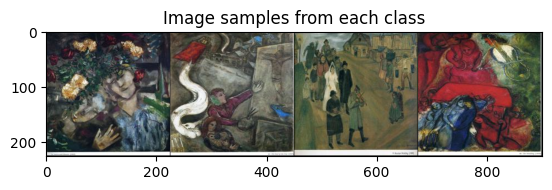

In [21]:
plot_tensor(val_dataset,class_id=3)

Showing samples from 20 tensors:


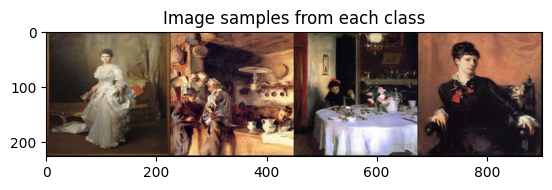

In [22]:
plot_tensor(val_dataset,class_id=4)

In [23]:
def get_meanstd(data):
    # List of lists of mean values for each image
    meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in data]
    stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in data]
    print('Mean & std values for sample:')
    print(meanRGB[0])
    print(stdRGB[0])

    # Calculate the global mean of the dataset from these means
    meanR = np.mean([m[0] for m in meanRGB])
    meanG = np.mean([m[1] for m in meanRGB])
    meanB = np.mean([m[2] for m in meanRGB])

    # Calculate the global standard deviation of the dataset
    stdR = np.mean([s[0] for s in stdRGB])
    stdG = np.mean([s[1] for s in stdRGB])
    stdB = np.mean([s[2] for s in stdRGB])

    print('\nMean value for dataset:')
    print(f'Mean Values: {meanR} {meanG} {meanB}')
    print(f'STD Values: {stdR} {stdG} {stdB}')

    return [meanR, meanG, meanB], [stdR, stdG, stdB]

means, stds = get_meanstd(train_dataset)


Mean & std values for sample:
[0.46218577 0.25881612 0.21213642]
[0.24350451 0.17115662 0.11441665]

Mean value for dataset:
Mean Values: 0.4929295480251312 0.4335843324661255 0.3677784204483032
STD Values: 0.22330835461616516 0.20628219842910767 0.18920010328292847


# Define the image transformations (for train_ds & test_all)

Showing samples from 400 tensors:


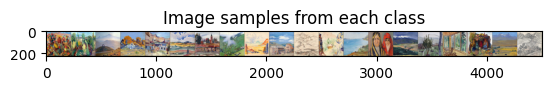

In [24]:
# Transformations for training set
train_transformer = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.RandomVerticalFlip(p=0.5),
                                        transforms.ToTensor(),
                                        transforms.Normalize([means[0], means[1], means[2]],
                                                             [stds[0], stds[1], stds[2]])])

# Standard transformations for test set
test0_transformer = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize([means[0], means[1], means[2]],
                                                             [stds[0], stds[1], stds[2]])])

''' Update the transform functions for train_ds & test_all '''
train_dataset.transform = train_transformer
test_dataset.transform = test0_transformer

plot_tensor(train_dataset, class_id=1)  # Can plot the converted data after transformation


# Create dataloaders from train_ds & val_ds

In [25]:
from torch.utils.data import DataLoader



# Create Data Loaders (training)
train_dl = DataLoader(train_dataset,
                      batch_size=32,
                      shuffle=True)

# Create Data Loader (validation)
val_dl = DataLoader(val_dataset,
                    batch_size=64,
                    shuffle=False)

# And get a batch of data from train_dl
for x,y in train_dl:
    print(x.shape)
    print(y.shape)
    break

# Extract a batch of data from val_dl
for x,y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([20, 3, 224, 224])
torch.Size([20])


# Defining a Loss Function

In [ ]:
loss_func = nn.CrossEntropyLoss(reduction='sum')

In [31]:
# get the current learning rate helper function
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [ ]:
def plot_out(loss_hist,metric_hist,epochs=None):

    # Train-Validation Progress
    fig = make_subplots(rows=1, cols=2,subplot_titles=['lost_hist','metric_hist'])

    # Plot Model Learning Rate
    fig.add_trace(go.Scatter(x=[*range(1,epochs+1)],
                             y=loss_hist["train"],
                             name='loss_hist["train"]',
                             line=dict(color="#0000ff")),row=1, col=1)
    fig.add_trace(go.Scatter(x=[*range(1,epochs+1)],
                             y=loss_hist["val"],
                             name='loss_hist["val"]'),row=1, col=1)

    # Plot Metric
    fig.add_trace(go.Scatter(x=[*range(1,epochs+1)],
                             y=metric_hist["train"],
                             name='metric_hist["train"]'),row=1, col=2)
    fig.add_trace(go.Scatter(x=[*range(1,epochs+1)],
                             y=metric_hist["val"],
                             name='metric_hist["val"]'),row=1, col=2)

    fig.update_layout(template='plotly_white')
    fig.update_layout(margin={"r":0,"t":60,"l":0,"b":0},height=300)
    fig.show()


# Training and Tranfer Learning

In [33]:
import copy


''' Helper function to count the number of correct predictions '''
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)

    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

''' Helper function to compute the loss value per batch of data '''
def loss_batch(loss_func, output, target, opt=None):

    # get loss
    loss = loss_func(output, target)

    # get performance metric
    metric_b = metrics_batch(output,target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Compute the Loss Value & Performance Metric

def loss_epoch(model,loss_func,dataset_dl,check_id=False,opt=None):

    # initialising variables
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop
    for xb, yb in dataset_dl:

        xb=xb.to(device) # move X of batch to device
        yb=yb.to(device) # move y of batch to device

        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        running_loss+=loss_b # update running loss

        if(metric_b is not None):
            running_metric+=metric_b # update running metric
        if(check_id):
            break # stop if only checking

    loss=running_loss/float(len_data) # average loss value
    metric=running_metric/float(len_data) # average metric value

    return loss, metric

In [34]:
''' TRAINING FUNCTION '''
# model - input model
# parameters - input parameter dictionary

def train_val(model, params, verbose = False):

    # extract model parameters
    epochs=params["epochs"]
    loss_func=params["loss_func"]
    opt=params["optimiser"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    check_id=params["check_id"]
    lr_scheduler=params["lr_scheduler"]
    path=params["path"]

    loss_history={"train": [],"val": []} # history of loss values in each epoch
    metric_history={"train": [],"val": []} # histroy of metric values in each epoch
    best_model_wts = copy.deepcopy(model.state_dict()) # copy weights for best model
    best_loss=float('inf') # initialize best loss to a large value

    # main loop
    for epoch in range(epochs):

        current_lr=get_lr(opt) # get current learning rate
        if(verbose):
            print(f"Epoch {epoch}/{epochs-1}, current lr={current_lr}")

        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,check_id,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        # evaluate model on validation dataset
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,check_id)


        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # store weights into a local file
            torch.save(model.state_dict(), path)
            if(verbose):
                print("Copied best model weights!")

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # learning rate schedule
        lr_scheduler.step()

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print('')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [35]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_out(loss_hist, metric_hist, epochs=None):
    # Crear la figura y los ejes
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Gráfico de historial de pérdidas
    axs[0].plot(range(1, epochs+1), loss_hist["train"], label="Train loss")
    axs[0].plot(range(1, epochs+1), loss_hist["val"], label="Validation loss")
    axs[0].set_title('loss_hist')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Gráfico de historial de métricas
    axs[1].plot(range(1, epochs+1), metric_hist["train"], label="Train acc")
    axs[1].plot(range(1, epochs+1), metric_hist["val"], label="Validation acc")
    axs[1].set_title('acc_hist')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    # Ajustar el espaciado entre los subplots
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()


## lr = 1e-4 and lr_scheduler ExponentialLR and optimizer Adagrad





In [28]:
import torch
import torch.nn as nn
import torchvision.models as models


pre_resnet50 = models.resnet50(pretrained=True)
num_ftrs = pre_resnet50.fc.in_features
pre_resnet50.fc = nn.Linear(num_ftrs, NUM_CLASSES)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pre_resnet50.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
loss_func = nn.CrossEntropyLoss(reduction='sum')

In [36]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

# loss function, optimiser, LR sheduler
loss_func = nn.CrossEntropyLoss(reduction="sum")

''' Define an optimiser '''
optimiser = optim.Adagrad(pre_resnet50.parameters(), lr=1e-4)

current_lr = get_lr(optimiser)
print(f'current lr = {current_lr}')

''' Define learning rate scheduler '''
lr_scheduler = ExponentialLR(optimiser, gamma=0.9)

# Set Training Parameters
params_train={
 "epochs": 200,
 "optimiser": optimiser,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "check_id": False,
 "lr_scheduler": lr_scheduler,
 "path": "pre_resnet50.pt",
}

# Train and validate the model
pre_resnet50,loss_hist,metric_hist=train_val(pre_resnet50,
                                             params_train,
                                             verbose=False)

current lr = 0.0001


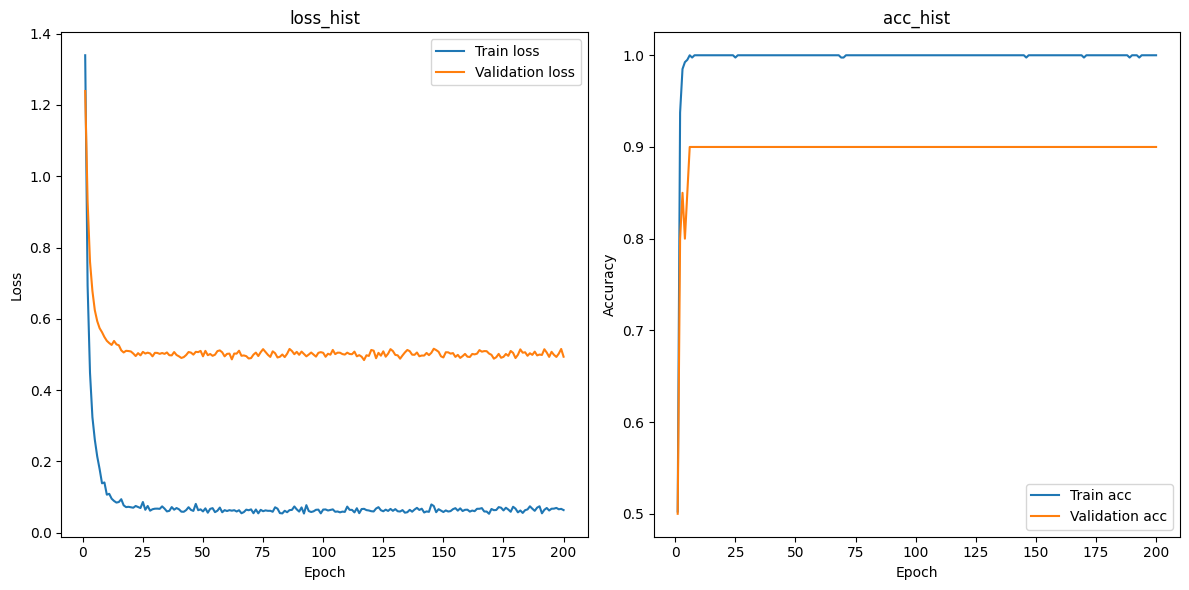

In [37]:
# Plot History
plot_out(loss_hist,metric_hist,epochs=params_train["epochs"])